<a href="https://colab.research.google.com/github/Deependrashukla/Deep-Learning/blob/main/LLM_Course_Inference_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install HuggingFace Transformers
!pip install --quiet transformers

In [ ]:
# Import the required libraries from Hugging Face Transformers
from transformers import AutoTokenizer, AutoModel

# There are a lot of BERT based models available on HuggingFace,
# and you have to pick one that is suitable for you.
BERT_Model = "bert-base-uncased"

# Initialize the tokenizer, which will break the input text into tokens (sub-words)
tokenizer = AutoTokenizer.from_pretrained(BERT_Model)

# Initialize the LLM that will take the tokens and output the embeddings
model = AutoModel.from_pretrained(BERT_Model)

# FOR SBERT
# model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Import the function to be used to compute the similarity between word embeddings
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
sum([param.numel() for param in model.parameters()])

109482240

#Compute the BERT embedding vectors for the SU chatbot data and:

- Find their PCA components (n=2) and see if they form any clusters.

- Do K-Means clustering of the full embedding vectors

- Compare the results from [CLS] and pooler_output

- Instead of the final layer, use embeddings from intermediate layers

- Make random changes in the model parameters and see its effect

Repeat the above with SBERT (try different models)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("/content/SUCHAT_EMB - Sheet1.csv")
df.head()

,question,answer
0,What is the fees?,Sitare University provides high quality Comput...
1,What is the cost of education?,Sitare University provides high quality Comput...
2,What is the curriculum?,The curriculum at Sitare University focuses on...
3,How are the faculty?,Sitare University has very high standards for ...
4,How many faculty are there?,"Currently, we have 5 full time faculty, and se..."


In [ ]:
def sent_embedding(sent):

    # Tokenize the sentence
    # This basically converts the sentence into a sequence of tokens
    # Each token is either a complete word or a sub-word
    tokens = tokenizer.encode_plus(sent, max_length=128, truncation=True,
                                    padding='max_length', return_tensors='pt')

    # Now feed the tokens into the model and get the embeddings as the output
    outputs = model(**tokens)

    # Create an empty list to store two different kinds of embeddings
    embedding_list = []

    # last_hidden_state contains the output at the last hidden layer of all the sentence tokens
    # pooler_output contains the embedding corresponding to only the [CLS] token, which in a way represents the whole sentence.
    # This pooler_output is, however, different from the embeddings corresponding to the 1st token of last_hidden_state
    # Although both represent the CLS token, the pooler_output is after some more processing,
    # and may be more suitable for use in some sentence related tasks.

    # This stores the embedding corresponding to the CLS token
    embedding_list.append(outputs.last_hidden_state[0][0].detach().numpy().reshape(1,-1))

    # This stores the embedding corresponding to the pooler_output
    embedding_list.append(outputs.pooler_output.detach().numpy())

    return embedding_list
    # return

In [ ]:

# Function to compute embeddings and store them in the DataFrame
def compute_embeddings(df):
    cls_embeddings = []
    pooler_outputs = []

    for sent in df['question']:
        embeddings = sent_embedding(sent)
        cls_embeddings.append(embeddings[0].flatten())
        pooler_outputs.append(embeddings[1].flatten())

    df['cls'] = cls_embeddings
    df['pooler_output'] = pooler_outputs


# Intermediate Layer Embeddings
# Modify `sent_embedding` to return intermediate layer outputs if needed
def sent_embedding_intermediate(sent, layer_num):
    # Assuming the model can return intermediate outputs
    tokens = tokenizer.encode_plus(sent, max_length=128, truncation=True,
                                    padding='max_length', return_tensors='pt')

    outputs = model(**tokens, output_hidden_states=True)

    # Get intermediate layer output
    intermediate_output = outputs.hidden_states[layer_num][0][0].detach().numpy().reshape(1, -1)

    return intermediate_output


# Normalization function
def normalize_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# PCA and KMeans functions (from previous code)
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data)
    return transformed_data

def apply_kmeans(data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    return kmeans.labels_, kmeans.cluster_centers_

# Function for plotting PCA results
def plot_pca(pca_data, title='PCA Result', xlabel='PCA 1', ylabel='PCA 2'):
    plt.figure(figsize=(10, 5))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Function for plotting KMeans results
def plot_kmeans(pca_data, labels, title='KMeans Clusters', xlabel='PCA 1', ylabel='PCA 2'):
    plt.figure(figsize=(10, 5))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.colorbar(label='Cluster Label')
    plt.grid(True)
    plt.show()



#PCA Component(2) Analysis

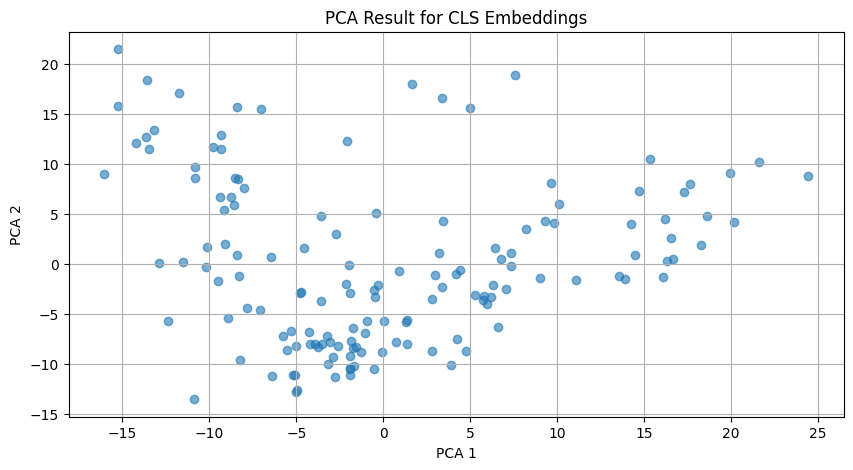

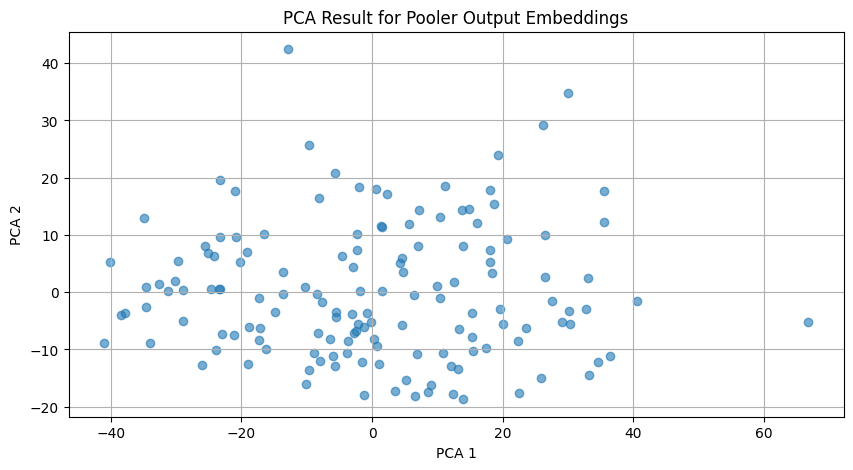

In [ ]:

# Compute embeddings
compute_embeddings(df)

# Normalize CLS and pooler_output
cls_normalized = normalize_data(np.array(df['cls'].tolist()))
pooler_normalized = normalize_data(np.array(df['pooler_output'].tolist()))

# Apply PCA
cls_pca = apply_pca(cls_normalized)
pooler_pca = apply_pca(pooler_normalized)

# PCA
plot_pca(cls_pca, title='PCA Result for CLS Embeddings')
plot_pca(pooler_pca, title='PCA Result for Pooler Output Embeddings')


#Kmeans Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


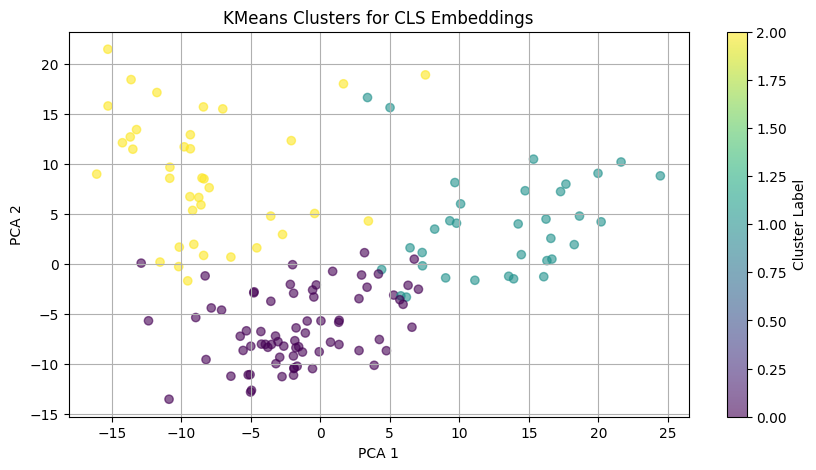

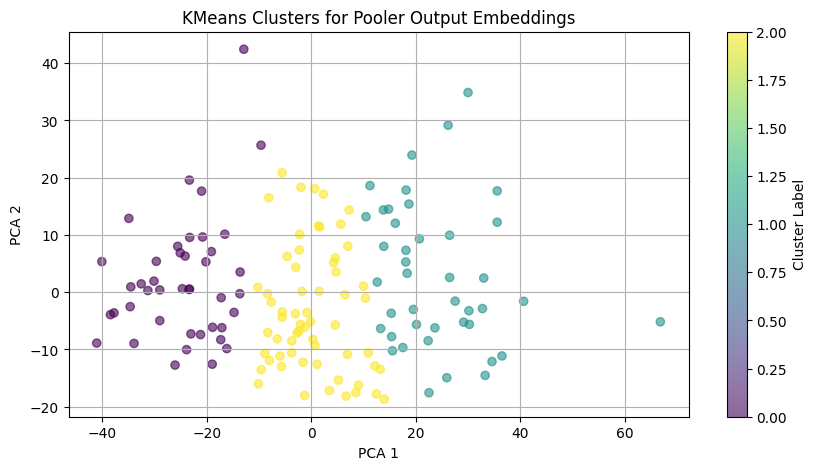

In [ ]:

# KMeans clustering
cls_labels, cls_centers = apply_kmeans(cls_normalized)
pooler_labels, pooler_centers = apply_kmeans(pooler_normalized)

# Add labels to DataFrame
df['cls_cluster'] = cls_labels
df['pooler_cluster'] = pooler_labels


# k-means
plot_kmeans(cls_pca, cls_labels, title='KMeans Clusters for CLS Embeddings')
plot_kmeans(pooler_pca, pooler_labels, title='KMeans Clusters for Pooler Output Embeddings')


#PCA and Kmeans for intermediate layer

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


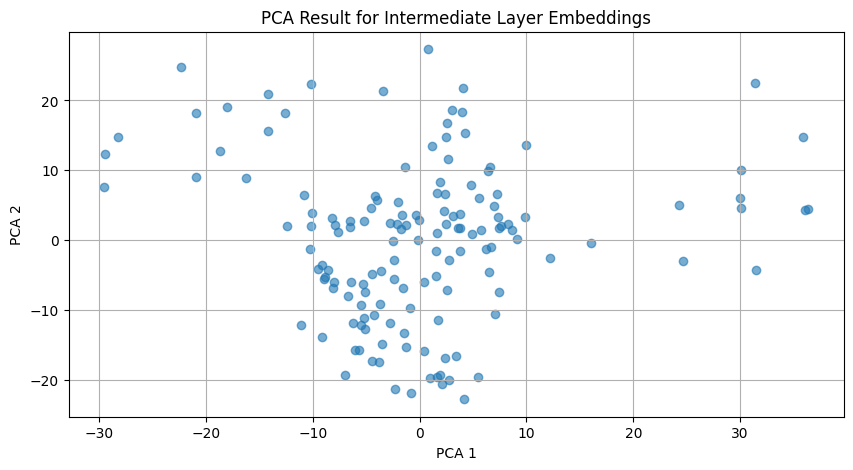

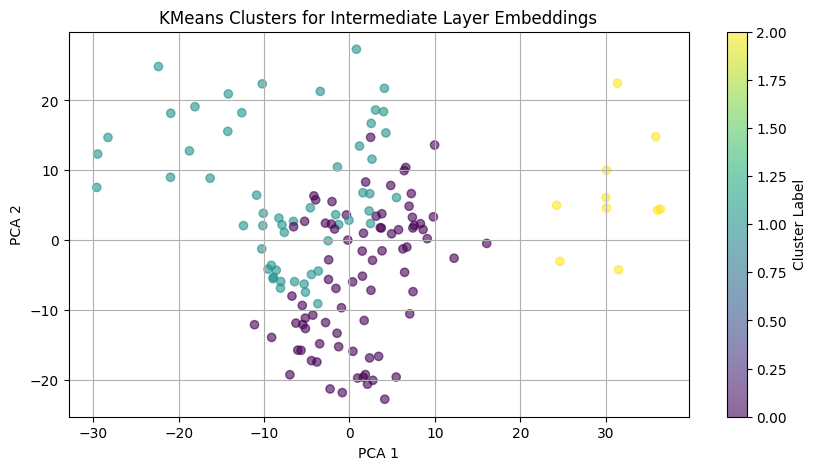

In [ ]:
# Function to average the embeddings along the sequence length dimension
def average_embeddings(embeddings):
    # embeddings shape: (sequence_length, hidden_size) -> output shape: (hidden_size,)
    return np.mean(embeddings, axis=1)  # Average across the sequence length

# Compute intermediate embeddings and average them
intermediate_embeddings = [(sent_embedding_intermediate(sent, layer_num=2)[0]) for sent in df['question']]
df['intermediate'] = intermediate_embeddings

# Now normalize the averaged intermediate embeddings
intermediate_normalized = normalize_data(np.array(df['intermediate'].tolist()))

# Apply PCA to the normalized intermediate embeddings
intermediate_pca = apply_pca(intermediate_normalized)

# Apply K-Means to the normalized intermediate embeddings
intermediate_labels, intermediate_centers = apply_kmeans(intermediate_normalized)

# Add cluster labels to the DataFrame
df['intermediate_cluster'] = intermediate_labels

# Plot PCA results for Intermediate Layer embeddings
plot_pca(intermediate_pca, title='PCA Result for Intermediate Layer Embeddings')

# Plot K-Means results for Intermediate Layer embeddings
plot_kmeans(intermediate_pca, intermediate_labels, title='KMeans Clusters for Intermediate Layer Embeddings')


#Kmeans for modified parameters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


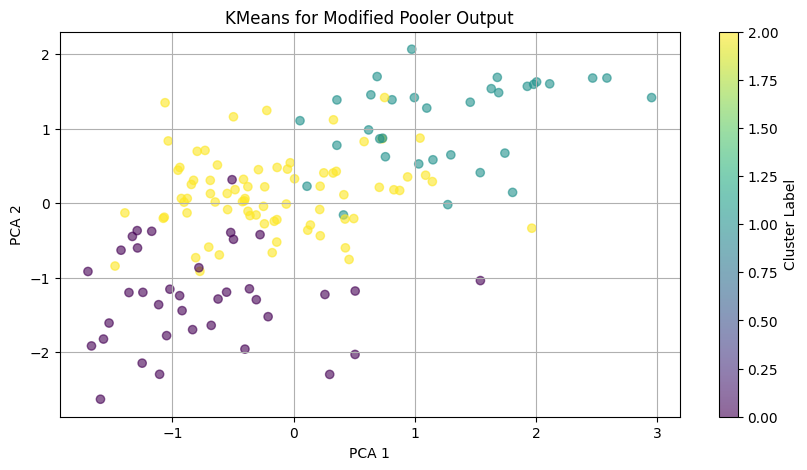

In [ ]:
import torch

# Function to modify model parameters randomly
def modify_model_weights(model, noise_factor=0.01):
    """
    Adds random noise to the model parameters.
    """
    with torch.no_grad():  # Disable gradient calculations
        for param in model.parameters():
            noise = torch.randn(param.size()) * noise_factor  # Generate random noise
            param.add_(noise)  # Add noise to the model parameters

modify_model_weights(model, noise_factor=0.01)  # Adjust noise factor as needed

compute_embeddings(df)  # Recompute embeddings with modified model
pooler_modified_normalized = normalize_data(np.array(df['pooler_output'].tolist()))  # Normalize modified pooler output

# Step 5: Perform K-Means on the modified pooler output embeddings
labels_modified, centers_modified = apply_kmeans(pooler_modified_normalized)
plot_kmeans(pooler_modified_normalized, labels_modified, title='KMeans for Modified Pooler Output')


# Tokenization using BERT

In [ ]:
sent = "Hava you watched the movie Serendipity?"

# Tokenize the sentence
# This basically converts the sentence into a sequence of tokens
# Each token is either a complete word or a sub-word

# encode_plus provides more functionality as compared to encode

tokens = tokenizer.encode_plus(sent, max_length=128, truncation=True,
                                padding='max_length', return_tensors='pt')

In [ ]:
type(tokens)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
# tokens is a dictionary with three keys : input_ids, token_type_ids and attention_mask

tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
input_ids = tokens['input_ids'][0]
print(input_ids)

tensor([  101,  5292,  3567,  2017,  3427,  1996,  3185, 14262, 10497, 11514,
         3012,  1029,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
print(type(tokens['input_ids']))
print(len(tokens['input_ids']))
print(tokens['input_ids'].shape)

<class 'torch.Tensor'>
1
torch.Size([1, 128])


In [ ]:
for token_id in input_ids:
    if token_id != 0:
        print(tokenizer.decode(token_id))

# Notice that all the letters in the words have small letters. Why do you think this is happening?

[CLS]
ha
##va
you
watched
the
movie
ser
##end
##ip
##ity
?
[SEP]


In [ ]:
tokenizer.convert_ids_to_tokens(input_ids)

['[CLS]',
 'ha',
 '##va',
 'you',
 'watched',
 'the',
 'movie',
 'ser',
 '##end',
 '##ip',
 '##ity',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[

In [ ]:
# token_type_ids are required only for specific tasks by Q&A, which we will learn later on.
token_type_ids = tokens['token_type_ids'][0]
print(token_type_ids)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
attention_mask = tokens['attention_mask'][0]
print(attention_mask)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


# Word Embeddings using BERT

In [ ]:
# Send the tokens through all the layers of the pre-trained BERT mode to get the output embeddings.
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
# last_hidden_state contains the output at the last hidden layer of all the sentence tokens
# pooler_output contains the embedding corresponding to only the [CLS] token, which in a way represents the whole sentence.
# This pooler_output is, however, different from the embeddings corresponding to the 1st token of last_hidden_state
# Although both represent the CLS token, the pooler_output is after some more processing,
# and more suitable for use in sentence classification tasks.

embeddings = outputs.last_hidden_state
cls_embeddings = outputs.pooler_output

print(embeddings.shape)
print(cls_embeddings.shape)

torch.Size([1, 128, 768])
torch.Size([1, 768])


In [ ]:
# Each token (sub-word) in the sentence is represented by a vector of size 768
print(len(embeddings[0][0]))
print(len(embeddings[0][1]))
print(len(embeddings[0][2]))

768
768
768


In [ ]:
embeddings[0][0]

tensor([ 3.4895e-01, -1.1710e-01, -1.6085e-01, -2.0282e-01,  7.4029e-03,
        -2.2611e-01,  1.1570e-01,  7.2159e-01, -3.9287e-01, -1.6468e-02,
         1.4102e-01,  1.8697e-01, -2.3238e-01,  3.2456e-01,  8.8067e-02,
         3.0324e-01, -3.3986e-01,  6.9119e-02,  3.6328e-01, -3.4930e-01,
         3.9969e-02, -5.2018e-01, -4.3323e-02, -2.5270e-01,  5.0896e-02,
        -1.5785e-01,  1.0078e-01,  4.2280e-01, -2.0821e-01,  1.0244e-01,
         1.6374e-01, -9.2105e-02, -2.9802e-01, -8.6023e-02, -1.2391e-01,
         4.6074e-02, -9.1638e-03,  3.2295e-01, -1.5261e-01,  1.6151e-01,
        -4.2247e-01,  1.7046e-01, -4.0814e-02, -2.0240e-01, -1.6093e-01,
        -4.4955e-02, -2.2958e+00,  3.5560e-01,  4.5410e-03, -2.1237e-01,
        -7.2672e-04,  2.4842e-01, -3.5592e-02,  1.8536e-01, -3.0001e-02,
         7.8590e-02, -3.3524e-01,  3.1456e-01, -1.5733e-01, -5.1020e-02,
         3.0713e-01, -1.4779e-01,  3.3689e-02,  1.4736e-01, -6.3929e-02,
         1.0246e-01,  7.4476e-02,  2.6032e-01, -1.7

# Contextual Similarity of Words

In [ ]:
sent_list = ["I love to watch TV",
        "I am wearing a wrist watch",
        "My brother goes to the ground every Sunday to watch Football",
        "My wife gifted me a beautiful watch on my birthday",
        "My wife gifted me a beautiful watch"]

In [ ]:
watch_embeddings = []

for sent in sent_list:
    tokens = tokenizer.encode_plus(sent, max_length=128, truncation=True,
                                    padding='max_length', return_tensors='pt')
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state

    input_ids = tokens['input_ids'][0]
    for i in range(len(input_ids)):
        if tokenizer.decode(input_ids[i]) == "watch":
            watch_embeddings.append(embeddings[0][i].detach().numpy().reshape(1,-1))

In [ ]:
cosine_similarity(watch_embeddings[0],watch_embeddings[1])

array([[0.3045428]], dtype=float32)

In [ ]:
cosine_similarity(watch_embeddings[0],watch_embeddings[2])

array([[0.71072936]], dtype=float32)

In [ ]:
cosine_similarity(watch_embeddings[1],watch_embeddings[3])

array([[0.43108273]], dtype=float32)

In [ ]:
cosine_similarity(watch_embeddings[1],watch_embeddings[4])

array([[0.84916127]], dtype=float32)

# Sentence Similarity using BERT

In [ ]:
def sent_embedding(sent):

    # Tokenize the sentence
    # This basically converts the sentence into a sequence of tokens
    # Each token is either a complete word or a sub-word
    tokens = tokenizer.encode_plus(sent, max_length=128, truncation=True,
                                    padding='max_length', return_tensors='pt')

    # Now feed the tokens into the model and get the embeddings as the output
    outputs = model(**tokens)

    # Create an empty list to store two different kinds of embeddings
    embedding_list = []

    # last_hidden_state contains the output at the last hidden layer of all the sentence tokens
    # pooler_output contains the embedding corresponding to only the [CLS] token, which in a way represents the whole sentence.
    # This pooler_output is, however, different from the embeddings corresponding to the 1st token of last_hidden_state
    # Although both represent the CLS token, the pooler_output is after some more processing,
    # and may be more suitable for use in some sentence related tasks.

    # This stores the embedding corresponding to the CLS token
    embedding_list.append(outputs.last_hidden_state[0][0].detach().numpy().reshape(1,-1))

    # This stores the embedding corresponding to the pooler_output
    embedding_list.append(outputs.pooler_output.detach().numpy())

    return embedding_list
    # return

In [ ]:
sent1 = "I am a human being."
sent2 = "What are you doing?"

In [ ]:
# Sentence similarity using CLS token embedding
cosine_similarity(sent_embedding(sent1)[0],sent_embedding(sent2)[0])

array([[0.87195206]], dtype=float32)

In [ ]:
# Sentence similarity using pooler_output
cosine_similarity(sent_embedding(sent1)[1],sent_embedding(sent2)[1])

array([[0.9270292]], dtype=float32)

# Sentence Similarity using SBERT

In [ ]:
!pip install --upgrade --quiet sentence-transformers==2.2.2

# Import the Sentence Transformer library
from sentence_transformers import SentenceTransformer, util

# There are several different Sentence Transformer models available on Hugging Face
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Convert the sentences into embeddings using the Sentence Transformer
sent_embedding1 = model.encode(sent1,convert_to_tensor=True)
sent_embedding2 = model.encode(sent2,convert_to_tensor=True)

In [ ]:
# Find the similarity between the two embeddings
util.pytorch_cos_sim(sent_embedding1, sent_embedding2)

tensor([[0.3407]])

**DIY:**

How will you use Sentence Similarity for Information Retrieval?

# Question-Answering using BERT

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
# from transformers import BertForQuestionAnswering
# from transformers import BertTokenizer

# model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'
model_path = "kaporter/bert-base-uncased-finetuned-squad"

#Tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = AutoTokenizer.from_pretrained(model_path)

#Model
# model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = AutoModelForQuestionAnswering.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# Triple quotes are used to create docstrings in python, or strings spanning several lines

question = '''What is Machine Learning?'''

# paragraph = '''Machine learning (ML) is the scientific study of algorithms and statistical models that computer systems use to progressively improve their performance
#                 on a specific task. Machine learning algorithms build a mathematical model of sample data, known as "training data", in order to make predictions or
#                 decisions without being explicitly programmed to perform the task. Machine learning algorithms are used in the applications of email filtering, detection
#                 of network intruders, and computer vision, where it is infeasible to develop an algorithm of specific instructions for performing the task. Machine learning
#                 is closely related to computational statistics, which focuses on making predictions using computers. The study of mathematical optimization delivers methods,
#                 theory and application domains to the field of machine learning. Data mining is a field of study within machine learning, and focuses on exploratory
#                 data analysis through unsupervised learning.In its application across business problems, machine learning is also referred to as predictive analytics.'''

paragraph = ""

encoding = tokenizer.encode_plus(text=question,text_pair=paragraph)

inputs = encoding['input_ids']  #Token embeddings
segment_mask = encoding['token_type_ids']  #Segment embeddings
tokens = tokenizer.convert_ids_to_tokens(inputs) #input tokens

In [ ]:
print(tokens)

['[CLS]', 'what', 'is', 'machine', 'learning', '?', '[SEP]']


In [ ]:
print(segment_mask)

[0, 0, 0, 0, 0, 0, 0]


In [ ]:
model_output = model(input_ids=torch.tensor([inputs]), token_type_ids=torch.tensor([segment_mask]))

In [ ]:
model_output.keys()

odict_keys(['start_logits', 'end_logits'])

In [ ]:
start_logits = model_output['start_logits']
end_logits = model_output['end_logits']

In [ ]:
start_index = int(torch.argmax(start_logits))
end_index = int(torch.argmax(end_logits))

print(start_index,end_index)

1 4


In [ ]:
answer = ' '.join(tokens[start_index:end_index+1])
print(answer)

what is machine learning


# Token Classification using BERT

 - Named Entity Recognition (NER)
 - POS Tagging

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

In [ ]:
# model_path = "distilbert-base-uncased"
model_path = "stevhliu/my_awesome_wnut_model"
# model_path = "Babelscape/wikineural-multilingual-ner"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/266M [00:00<?, ?B/s]

In [ ]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [ ]:
example = "My name is Wolfgang and I live in India."
ner_results = nlp(example)

In [ ]:
print(ner_results)

[{'entity_group': 'person', 'score': 0.916228, 'word': 'wolfgang', 'start': 11, 'end': 19}, {'entity_group': 'location', 'score': 0.6462099, 'word': 'india', 'start': 34, 'end': 39}]


In [ ]:
type(ner_results)

list

In [ ]:
len(ner_results)

2

In [ ]:
for item in ner_results:
    print(item['word'], " : ", item['entity_group'])

wolfgang  :  person
india  :  location
